In [11]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import keras
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

base = '/content/COVID-19_Radiography_Dataset/'

In [15]:
folders = os.listdir(base)
print(folders)

['Normal', 'COVID', 'Viral Pneumonia', 'Lung_Opacity']


In [50]:
%%time

Data, Lables = [], []

for item in folders:
  new_path = os.path.join(base, item)
  new_path += '/images'
  for img in os.listdir(new_path):
    img_path = os.path.join(new_path, img)
    Data.append(np.array(cv2.resize(cv2.imread(img_path).astype('float32'), (72,72))))
    Lables.append(folders.index(item))

CPU times: user 53.9 s, sys: 14.6 s, total: 1min 8s
Wall time: 58 s


In [51]:
Data = np.array(Data)
Lables = np.array(Lables)
print('Data Shape', Data.shape)
print('Lable Shape', Lables.shape)

Data Shape (21165, 72, 72, 3)
Lable Shape (21165,)


In [52]:
x_train, x_test, y_train, y_test = train_test_split(Data, Lables, test_size = .2, random_state = 1)

In [53]:
print('x_train Shape', x_train.shape)
print('x_test Shape', x_test.shape)
print('y_train Shape', y_train.shape)
print('y_test Shape', y_test.shape)

x_train Shape (16932, 72, 72, 3)
x_test Shape (4233, 72, 72, 3)
y_train Shape (16932,)
y_test Shape (4233,)


In [64]:
input_shape = Data[0].shape
num_classes = len(folders)
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 72  # Initial image size

num_patch_x = Data[0].shape[0] // patch_size[0]
num_patch_y = Data[0].shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [65]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(keras.layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

In [66]:
class WindowAttention(keras.layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = keras.layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = keras.layers.Dropout(dropout_rate)
        self.proj = keras.layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

In [67]:
class SwinTransformer(keras.layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = keras.layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                keras.layers.Dense(num_mlp),
                keras.layers.Activation(keras.activations.gelu),
                keras.layers.Dropout(dropout_rate),
                keras.layers.Dense(dim),
                keras.layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

In [68]:
class PatchExtract(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = keras.layers.Dense(embed_dim)
        self.pos_embed = keras.layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = keras.layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

In [75]:
input = keras.layers.Input(input_shape)
x =  keras.layers.RandomCrop(image_dimension, image_dimension)(input)
x =  keras.layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x =  keras.layers.GlobalAveragePooling1D()(x)
output =  keras.layers.Dense(num_classes, activation="softmax")(x)

In [77]:
%%time
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data = (x_test, y_test),
)

Epoch 1/40
133/133 [==============================] - 48s 332ms/step - loss: 19.4207 - accuracy: 0.4685 - val_loss: 8.6570 - val_accuracy: 0.9983
Epoch 2/40
133/133 [==============================] - 44s 328ms/step - loss: 7.5188 - accuracy: 0.4930 - val_loss: 1.6729 - val_accuracy: 0.8531
Epoch 3/40
133/133 [==============================] - 44s 330ms/step - loss: 4.1298 - accuracy: 0.4923 - val_loss: 2.6569 - val_accuracy: 0.9714
Epoch 4/40
133/133 [==============================] - 44s 330ms/step - loss: 4.0520 - accuracy: 0.4966 - val_loss: 1.2865 - val_accuracy: 0.8547
Epoch 5/40
133/133 [==============================] - 44s 331ms/step - loss: 1.5766 - accuracy: 0.5471 - val_loss: 1.4811 - val_accuracy: 0.5762
Epoch 6/40
133/133 [==============================] - 44s 331ms/step - loss: 1.3287 - accuracy: 0.5494 - val_loss: 1.0740 - val_accuracy: 0.7600
Epoch 7/40
133/133 [==============================] - 44s 331ms/step - loss: 1.3652 - accuracy: 0.5556 - val_loss: 1.4112 - val_a

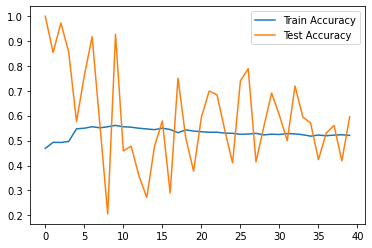

In [78]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Test Accuracy')
plt.legend()
plt.show()

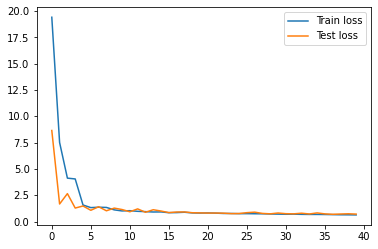

In [79]:
plt.plot(history.history['loss'], label = 'Train loss')
plt.plot(history.history['val_loss'], label = 'Test loss')
plt.legend()
plt.show()

In [80]:
model.evaluate(x_test, y_test)

133/133 [==============================] - 4s 29ms/step - loss: 0.7193 - accuracy: 0.5923


[0.7193124294281006, 0.5922513604164124]